<a href="https://colab.research.google.com/github/cyrus-rule/Data-Science-/blob/main/CyruRuleU7proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Intro

In [139]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr

Your file on your github needs to be a a .ipynb file with the first four letters of one first name, the first four letters of one last name, and U6proj.

Ex1.

A student named Avy Aguacate Avocado Palta will submit a file named "Avy_AvocU7proj.ipynb", since she normally just goes by Avy, and, when pressed, reports Avocado as her last name. The " _ " after "Avy" serves as the fourth "letter" in her first name.

Ex2.

Army Armadillo will submit a file named "ArmyArmaU7proj.ipynb"

# Unit 7 Project: Polynomials, Splines, and GPs, Oh my!

**Task**:

Two parts:

1. Propose a data set that's compatible with pymc and/or bambi. I must approve your submission before you move on to part 2.

2. Create, analyze, and present any guassian process or approximate GP, degenerate or otherwise (this means glms and b splines are allowed), using pymc within the colab environment, on a data set of your choice, with the following conditions:
  - your final model must have more than 2 predictors. The intercept term doesn't count as a predictor here (even though technically it is), or if must be an actual GP
  - You must document and explain your model selection method. This means you must argue that your model choice (glm, b spline, GP) is better than at least one other choice. You may use either a theoretical or numerical argument.



Guidlines:

- Your data or your model type must be different from any project you've previously done.

- You are allowed to copy and paste any code from the notes, including my answer key (AK), without any reference or citations. Same goes for the course textbook, BAP3.

- This is an individual project. It is fine if you model the same process as a peer, but your raw data **must** be substantially different. "Substantially different" means that I, your instructor, arbitrarily think your data sets are different enough.

- Do not look at other student's code/jupyter notebooks. Copying, or copying and pasting, other students code will result in a failing grade. Also, I will tell all the other teachers I know that you cheated.

- If you want to know what another student did, ask them--any verbal communication about a project is allowed and encouraged. If you want to see a graphic they made, ask them to sketch a picture of it for you by hand.

- Any handwritten communication is also allowed and encouraged, so long as all parties are in the same physical location together. Example: you may sketch out a piece of code while verbally explaining to someone what you did. Do NOT: hand write the code for your entire project, take a picture, and send it to everyone in the course.

- If you use someone's code from outside this course (like from the internet, an AI, or your parent), you must ask me if it is ok, and you must cite them in your work. I don't care all they did was to click your space bar one more time: you tell me, and you cite their contribution. You don't need to tell me about or cite verbal or handwritten communication though.

- You may use a more complicated model--like something from further along in the course--IF I give you permission.

- If you are unsure whether or not something is ok or allowed: ASK BEFORE YOU DO IT.

Faliure to adhere to these guidlines will result in a failing grade.

Tips:

- Try to pick something that you care about, have knowledge of, experience with, or that you find interesting/cool.

- Gather data *before* picking a model or likelihood.

-  Use your best idea now; maybe you can look at the context you used in the previous project, and gather different data from it.

- Choose a data set with lots of columns, and lots of potential interactions between variables. It'll be more fun, and will make model/variable selection more relevant.

- This is not a competition to come up with the fanciest model structure. Find a data set that interests you, and apply the simplest model that captures the patterns in the data.

- Comment heavily, and explain your steps and thought process with text blocks. This is not only requried, it'll also help you understand what you're doing and what you want to do.

- I actually encourge you to use b splines; they work quite well, and trying to determine the location of the knots requires careful thought about the context of the data.

- Its ok to pick a data set for which you don't qute understand the context--so long as you think the context is cool.


We're gonna make a gaussian process to predict bike rentals (kinda) in the city of chicago based on this bunch of data i have here. We will have 3 predictors (x position, y position, and time) and 1 predicted value, the rate of bike rentals at that place and time

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/cyrus-rule/Data-Science-/refs/heads/main/biketrips.csv')

In [ ]:
data

,days,minutes,tripduration,from_station_name,to_station_name
0,180,1437,604,Lincoln Ave & Belmont Ave,Broadway & Cornelia Ave
1,180,1436,263,Halsted St & Maxwell St,May St & Taylor St
2,180,1413,126,Sheffield Ave & Webster Ave,Halsted St & Dickens Ave
3,180,1406,3481,Peoria St & Jackson Blvd,State St & Wacker Dr
4,180,1396,638,Loomis St & Lexington St,Peoria St & Jackson Blvd
...,...,...,...,...,...
86780,174,1,1603,Cannon Dr & Fullerton Ave,Theater on the Lake
86781,174,0,1603,Cannon Dr & Fullerton Ave,Theater on the Lake
86782,174,0,753,California Ave & North Ave,Kedzie Ave & Milwaukee Ave
86783,174,0,5529,Clark St & Chicago Ave,Sheridan Rd & Lawrence Ave


Getting coordinates and dealing with shenanagins

In [ ]:
%pip install geopy
from geopy.geocoders import Nominatim
import time

geolocator = Nominatim(user_agent="bike_rental_model")

def get_coordinates(station_name, max_retries=2):
    for attempt in range(max_retries):
        try:
            location = geolocator.geocode(f"{station_name}, Chicago, IL", timeout=10)
            if location:
                return (location.latitude, location.longitude)
            else:
                return (None, None)
        except:
            return (None, None)

station_name = "Lincoln Ave & Leavitt St"
print(get_coordinates(station_name))


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
(None, None)


In [ ]:
unique_stations = pd.concat([data['from_station_name'], data['to_station_name']]).unique()

In [ ]:
unique_stations

array(['Lincoln Ave & Belmont Ave', 'Halsted St & Maxwell St',
       'Sheffield Ave & Webster Ave', 'Peoria St & Jackson Blvd',
       'Loomis St & Lexington St', 'Halsted St & Diversey Pkwy',
       'Canal St & Madison St', 'Wabash Ave & Grand Ave',
       'Larrabee St & Armitage Ave', 'Ravenswood Ave & Montrose Ave',
       'State St & 19th St', 'Canal St & Harrison St',
       'Orleans St & Merchandise Mart Plaza', 'Lake Park Ave & 47th St',
       'Museum Campus', 'Clark St & Congress Pkwy',
       'Ashland Ave & Division St', 'Aberdeen St & Madison St',
       'Franklin St & Chicago Ave', 'Racine Ave & Belmont Ave',
       'LaSalle St & Illinois St', 'Wells St & Concord Ln',
       'Michigan Ave & Congress Pkwy', 'McClurg Ct & Illinois St',
       'Michigan Ave & Pearson St', 'Mies van der Rohe Way & Chicago Ave',
       'Ashland Ave & Augusta Blvd', 'Theater on the Lake',
       'Fairbanks Ct & Grand Ave', 'Franklin St & Arcade Pl',
       'Sheridan Rd & Irving Park Rd', 'Wells 

In [ ]:
station_coords = {}
for station in unique_stations:
    try:
        station_coords[station] = get_coordinates(station)
    except:
        station_coords[station] = (0, 0)
    time.sleep(1)

In [ ]:
failed_coords = {}
for station, coords in station_coords.items():
    if coords == (None, None):
        failed_coords[station] = coords

In [ ]:
failed_coords

{'Halsted St & Diversey Pkwy': (None, None),
 'Clark St & Congress Pkwy': (None, None),
 'Michigan Ave & Congress Pkwy': (None, None),
 'Franklin St & Arcade Pl': (None, None),
 'May St & Randolph St': (None, None),
 'Halsted St & James M Rochford St': (None, None),
 'Lincoln Ave & Leavitt St': (None, None),
 'Wabash Ave & 8th St': (None, None),
 'Wood St & Division St': (None, None),
 'Halsted St & Blackhawk St': (None, None),
 'Clark St & Waveland Ave': (None, None),
 'Wells St & Erie St': (None, None),
 'Halsted St & Waveland Ave': (None, None),
 'Shore Drive & 55th St': (None, None),
 'Martin Luther King Dr & 29th St': (None, None),
 'Morgan Ave & 14th Pl': (None, None),
 'Cityfront Plaza & N Water St': (None, None),
 'State St & Erie St': (None, None),
 'Hampden Ct & Diversey Pkwy': (None, None),
 'Sheffield Ave & Addison St': (None, None),
 'Canal St & Monroe St': (None, None),
 'Leavitt St & Hirsch St': (None, None),
 'Marshfield Ave & Cortland St': (None, None),
 'Lincoln Ave &

In [ ]:
station_coords['Halsted St & Diversey Pkwy'] = (41.933524085111316, -87.64906976642908)
station_coords['Clark St & Congress Pkwy'] = (41.87655110680505, -87.63089821249358)
station_coords['Michigan Ave & Congress Pkwy'] = (41.87638767251824, -87.62445464317649)
station_coords['Franklin St & Arcade Pl'] = (41.881929330510225, -87.63548545851417)
station_coords['May St & Randolph St'] = (41.884808691957375, -87.6556910818046)
station_coords['Halsted St & James M Rochford St'] = (41.86636802981053, -87.64695128181751)
station_coords['Lincoln Ave & Leavitt St'] = (41.96193398243927, -87.68362050504314)
station_coords['Wabash Ave & 8th St'] = (41.87236979771138, -87.62592955113041)
station_coords['Wood St & Division St'] = (41.90397643248606, -87.6724796817913)
station_coords['Halsted St & Blackhawk St'] = (41.909179760845575, -87.64821705110462)
station_coords['Clark St & Waveland Ave'] = (41.94960557634526, -87.65804078175913)
station_coords['Wells St & Erie St'] = (41.89463024453914, -87.6342201817978)
station_coords['Halsted St & Waveland Ave'] = (41.94979311013272, -87.64964008175903)
station_coords['Shore Drive & 55th St'] = (41.79567997013598, -87.58083885118413)
station_coords['Martin Luther King Dr & 29th St'] = (41.842841847672865, -87.61729568183424)
station_coords['Morgan Ave & 14th Pl'] = (41.862954222598155, -87.65098178182005)
station_coords['Cityfront Plaza & N Water St'] = (41.89070044727213, -87.62188618180043)
station_coords['State St & Erie St'] = (41.894561818296786, -87.62852428918804)
station_coords['Hampden Ct & Diversey Pkwy'] = (41.933395778631386, -87.64239370506313)
station_coords['Sheffield Ave & Addison St'] = (41.94794924825625, -87.6540685590286)
station_coords['Canal St & Monroe St'] = (41.881004715799826, -87.63983341249012)
station_coords['Leavitt St & Hirsch St'] = (41.90736167813068, -87.68220603576442)
station_coords['Marshfield Ave & Cortland St'] = (41.91660368718168, -87.66903133575786)
station_coords['Lincoln Ave & Eastwood Ave'] = (41.9662523989026, -87.6868143124303)
station_coords['Wood St & North Ave'] = (41.91123251550038, -87.67258325110319)
station_coords['Green St & Milwaukee Ave'] = (41.89245613409787, -87.64872622043328)
station_coords['Clifton Ave & Lawrence Ave'] = (41.96974180812307, -87.6588499357206)
station_coords['Franklin St & Quincy St'] = (41.879091675196555, -87.63531518180854)
station_coords['Ashland Ave & 21st St'] = (41.85461005267431, -87.66606898182572)
station_coords['Wood St & Grand Ave'] = (41.89132784867051, -87.67228054316581)
station_coords['Wallace Ave & 35th St'] = (41.831556506035014, -87.64115392047624)
station_coords['Paulina St & Diversey Pkwy'] = (41.93301696033661, -87.67082795108789)
station_coords['Martin Luther King Dr & Oakwood Blvd'] = (41.823033811467795, -87.61683259718936)


In [ ]:
station_coords

{'Lincoln Ave & Belmont Ave': (41.9393041, -87.6682778),
 'Halsted St & Maxwell St': (41.8648187, -87.6471285),
 'Sheffield Ave & Webster Ave': (41.921687, -87.653714),
 'Peoria St & Jackson Blvd': (41.8777021, -87.6496545),
 'Loomis St & Lexington St': (41.8721652, -87.6614337),
 'Halsted St & Diversey Pkwy': (41.933524085111316, -87.64906976642908),
 'Canal St & Madison St': (41.881654499999996, -87.6395711762474),
 'Wabash Ave & Grand Ave': (41.8914225, -87.6267774),
 'Larrabee St & Armitage Ave': (41.9180783, -87.6437469),
 'Ravenswood Ave & Montrose Ave': (41.9614245, -87.6762198),
 'State St & 19th St': (41.856594, -87.627542),
 'Canal St & Harrison St': (41.8742451, -87.6395767),
 'Orleans St & Merchandise Mart Plaza': (41.8883141, -87.6364539),
 'Lake Park Ave & 47th St': (41.80943, -87.5918871),
 'Museum Campus': (41.8685933, -87.6156365),
 'Clark St & Congress Pkwy': (41.87655110680505, -87.63089821249358),
 'Ashland Ave & Division St': (41.903455, -87.66788),
 'Aberdeen St &

In [ ]:
data['from_coords'] = data['from_station_name'].apply(lambda x: station_coords[x])
data['to_coords'] = data['to_station_name'].apply(lambda x: station_coords[x])

In [ ]:
data

,days,minutes,tripduration,from_station_name,to_station_name,from_coords,to_coords
0,180,1437,604,Lincoln Ave & Belmont Ave,Broadway & Cornelia Ave,"(41.9393041, -87.6682778)","(41.9455138, -87.6464769)"
1,180,1436,263,Halsted St & Maxwell St,May St & Taylor St,"(41.8648187, -87.6471285)","(41.8693885, -87.6554754)"
2,180,1413,126,Sheffield Ave & Webster Ave,Halsted St & Dickens Ave,"(41.921687, -87.653714)","(41.919936, -87.64883)"
3,180,1406,3481,Peoria St & Jackson Blvd,State St & Wacker Dr,"(41.8777021, -87.6496545)","(41.88782981167939, -87.6280594929474)"
4,180,1396,638,Loomis St & Lexington St,Peoria St & Jackson Blvd,"(41.8721652, -87.6614337)","(41.8777021, -87.6496545)"
...,...,...,...,...,...,...,...
86780,174,1,1603,Cannon Dr & Fullerton Ave,Theater on the Lake,"(41.926752, -87.634457)","(41.9262421, -87.6309574)"
86781,174,0,1603,Cannon Dr & Fullerton Ave,Theater on the Lake,"(41.926752, -87.634457)","(41.9262421, -87.6309574)"
86782,174,0,753,California Ave & North Ave,Kedzie Ave & Milwaukee Ave,"(41.9104606, -87.6969033)","(41.92958995, -87.70790961887985)"
86783,174,0,5529,Clark St & Chicago Ave,Sheridan Rd & Lawrence Ave,"(41.8967397, -87.6307486)","(41.969517, -87.654691)"


In [ ]:
data.to_csv('biketrips_with_coordinates.csv', index=False)

from google.colab import files
files.download('biketrips_with_coordinates.csv')


NameError: name 'data' is not defined

# Data

I saved the updated data just so i dont have to do all of that again

In [162]:
data = pd.read_csv('https://raw.githubusercontent.com/cyrus-rule/Data-Science-/refs/heads/main/biketrips_with_coordinates.csv')

In [163]:
station_coords = {}
for index, row in data.iterrows():
    station_name = row['from_station_name']
    if station_name not in station_coords:
        coords_str = row['from_coords'].strip('()').split(', ')
        latitude = float(coords_str[0])
        longitude = float(coords_str[1])
        station_coords[station_name] = (latitude, longitude)

<Axes: >

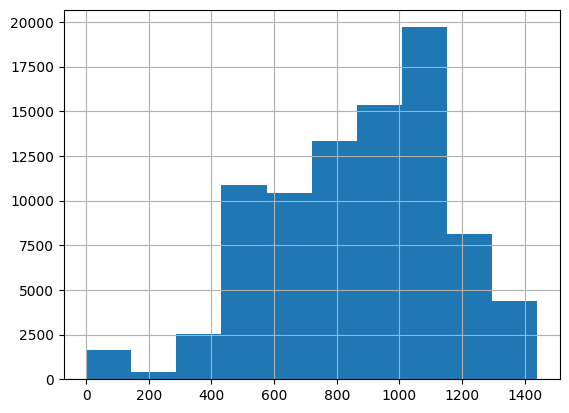

In [164]:
data.minutes.hist()

There seems to be a big spike in the afternoon / evening and very little activity in the early morning

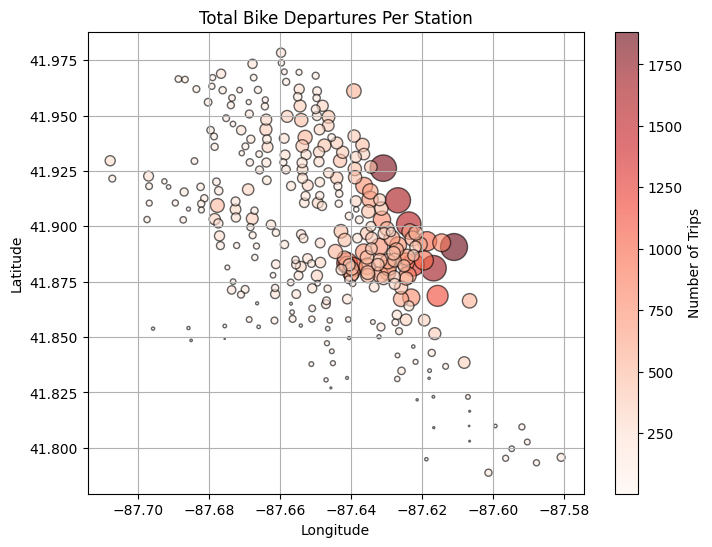

In [165]:
# Count trips per station
station_trip_counts = data['from_station_name'].value_counts()
stations = pd.DataFrame({'station': station_trip_counts.index, 'trips': station_trip_counts.values})

# Merge with coordinates
stations['coords'] = stations['station'].map(station_coords)
stations[['latitude', 'longitude']] = stations['coords'].apply(lambda x: pd.Series(x))

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(stations['longitude'], stations['latitude'], s=stations['trips']/5, alpha=0.6, c=stations['trips'], cmap='Reds', edgecolors="black")
plt.colorbar(label="Number of Trips")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Total Bike Departures Per Station")
plt.grid(True)
plt.show()

Interesting, geographic location is definitely a factor in determining popularity

In [166]:
import folium
import branca.colormap as cm
# Get the center of the map
map_center = [stations['latitude'].mean(), stations['longitude'].mean()]

# Create map with folium
m = folium.Map(location=map_center, zoom_start=12)

# Create color scale
colormap = cm.linear.YlOrRd_09.scale(stations['trips'].min(), stations['trips'].max())

# Normalize trip counts for marker size
max_trips = stations['trips'].max()

# Add circles for each station
for _, row in stations.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5 + (row['trips'] / max_trips) * 15,  # Scale size
        color=colormap(row['trips']),  # Color based on trips
        fill=True,
        fill_color=colormap(row['trips']),
        fill_opacity=0.7,
        popup=f"{row['station']}: {row['trips']} trips",
    ).add_to(m)

# Add color legend
colormap.caption = "Number of Trips"
colormap.add_to(m)

# Display the map
m

That was pretty cool to make, and it gives some context to what we saw before. Places on the lake, on the chicago river, and specifically on the navy pier are very very popular and popularity decreases as we go away from those areas.

# Models

In [167]:
#aggregate trips from the same station and time of day

grouped = data.groupby(['from_station_name', 'minutes']).size().reset_index(name='trips')

#put in coordinates

grouped['coords'] = grouped['from_station_name'].apply(lambda x: station_coords[x])
grouped[['latitude', 'longitude']] = grouped['coords'].apply(lambda x: pd.Series(x))

In [168]:
# Input Matrix
X = grouped[['minutes', 'latitude', 'longitude']].values
# Output matrix
y = grouped['trips'].values

I commented out old models that didn't work because they take forever / crash

In [169]:

# with pm.Model() as gp_model:
#     # Hyperparameters for the time kernel (but set full input_dim=3)
#     ls_time = pm.Gamma("ls_time", alpha=2, beta=1) #Ensures positive values and i don't think popularity changes too quickly
#     period = 1440  # minutes in a day
#     cov_time = pm.gp.cov.Periodic(3, ls=ls_time, period=period, active_dims=[0])
#
#     # Hyperparameters for the spatial kernel (also set input_dim=3)
#     ls_space = pm.Gamma("ls_space", alpha=2, beta=1) #Positive, kinda smooth
#     cov_space = pm.gp.cov.Matern52(3, ls=ls_space, active_dims=[1, 2])
#
#     cov = cov_time * cov_space # multiplying them basically means that i think space and time interact
#
#     # Create the GP object
#     gp = pm.gp.Marginal(cov_func=cov)
#
#     sigma = pm.HalfCauchy("sigma", beta=5) #noise term
#     y_obs = gp.marginal_likelihood("y_obs", X=X, y=y, noise=sigma)
#
#     trace = pm.sample(500, tune=500, target_accept=0.9)


The above model overloaded collabs memory and crashed so i instead tried a sparcce gp

In [170]:
# m = 100
#
# X_u = X[np.random.choice(X.shape[0], size=m, replace=False)]
#
# with pm.Model() as gp_model:
#     ls_time = pm.Gamma("ls_time", alpha=2, beta=1)
#     period = 1440
#     cov_time = pm.gp.cov.Periodic(3, ls=ls_time, period=period, active_dims=[0])
#
#     ls_space = pm.Gamma("ls_space", alpha=2, beta=1)
#     cov_space = pm.gp.cov.Matern52(3, ls=ls_space, active_dims=[1, 2])
#
#     cov = cov_time * cov_space
#
#     # Use a sparse GP approximation
#     gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")  #doesn't use every single point, picks m inducing points
#
#     sigma = pm.HalfCauchy("sigma", beta=5)
#
#     # Pass the inducing inputs as X_u
#     y_obs = gp.marginal_likelihood("y_obs", X=X, y=y, noise=sigma, Xu=X_u)
#
#     trace = pm.sample(500, tune=500, target_accept=0.9)

That still crashed, so i decided to group the times together by 30 minute intervals

In [171]:
grouped['time_bin'] = (grouped['minutes'] // 30) * 30


In [172]:
grouped = grouped.groupby(['from_station_name', 'time_bin']).agg({
    'trips': 'sum',
    'coords': 'first',
    'latitude': 'first',
    'longitude': 'first'
}).reset_index()


In [173]:
grouped

,from_station_name,time_bin,trips,coords,latitude,longitude
0,900 W Harrison,0,1,"(41.8743102, -87.6494554)",41.874310,-87.649455
1,900 W Harrison,60,1,"(41.8743102, -87.6494554)",41.874310,-87.649455
2,900 W Harrison,510,4,"(41.8743102, -87.6494554)",41.874310,-87.649455
3,900 W Harrison,540,4,"(41.8743102, -87.6494554)",41.874310,-87.649455
4,900 W Harrison,570,2,"(41.8743102, -87.6494554)",41.874310,-87.649455
...,...,...,...,...,...,...
10431,Woodlawn Ave & 55th St,1170,2,"(41.795264, -87.596471)",41.795264,-87.596471
10432,Woodlawn Ave & 55th St,1200,1,"(41.795264, -87.596471)",41.795264,-87.596471
10433,Woodlawn Ave & 55th St,1260,2,"(41.795264, -87.596471)",41.795264,-87.596471
10434,Woodlawn Ave & 55th St,1290,1,"(41.795264, -87.596471)",41.795264,-87.596471


In [174]:
# m = 100
# X_u = X[np.random.choice(X.shape[0], size=m, replace=False)]
#
# with pm.Model() as gp_model:
#     ls_time = pm.Gamma("ls_time", alpha=2, beta=1)
#     period = 1440  # minutes in a day
#     cov_time = pm.gp.cov.Periodic(3, ls=ls_time, period=period, active_dims=[0])
#
#     ls_space = pm.Gamma("ls_space", alpha=2, beta=1)
#     cov_space = pm.gp.cov.Matern52(3, ls=ls_space, active_dims=[1, 2])
#
#     cov = cov_time * cov_space
#
#     # Use a sparse GP approximation
#     gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")
#
#     sigma = pm.HalfCauchy("sigma", beta=5)
#
#     # Pass the inducing inputs as X_u
#     y_obs = gp.marginal_likelihood("y_obs", X=X, y=y, noise=sigma, Xu=X_u)
#
#     trace = pm.sample(500, tune=500, target_accept=0.9)

I tried to save this model using pickle and it did not work (My model had much less predictive power after being saved).

In [175]:
import pickle
import cloudpickle


In [176]:
# import cloudpickle
#
# with open('gp_model.pkl', 'wb') as buff:
#     cloudpickle.dump({'model': gp_model, 'trace': trace}, buff)

In [177]:
# with open('gp_model.pkl', 'rb') as buff:
#    data1 = pickle.load(buff)
#    gp_model1 = data1['model']
#    trace1 = data1['trace']

In [178]:
# gp_model

In [179]:
# gp_model1

Post Pickle
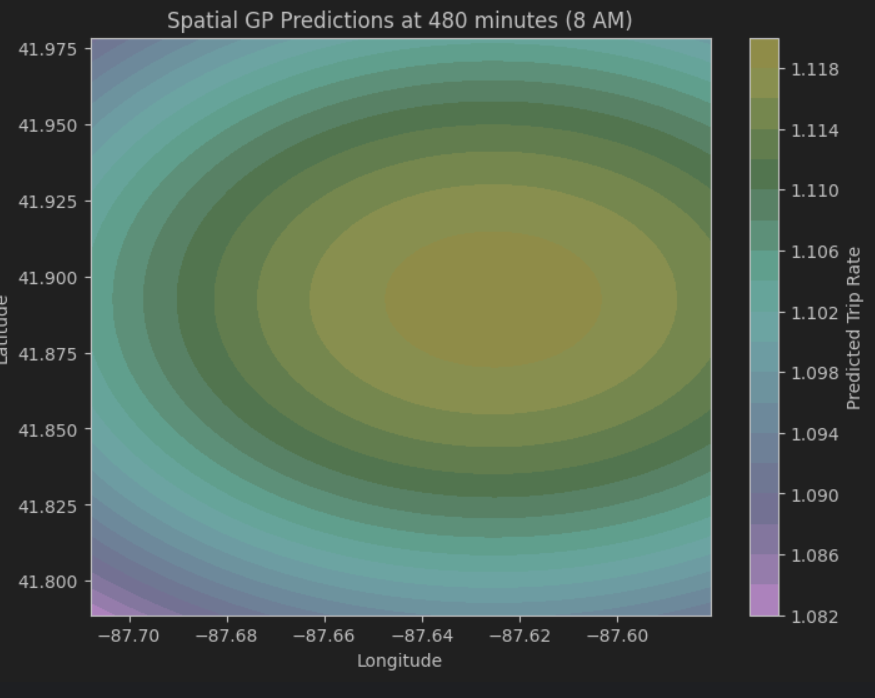
Pre Pickle
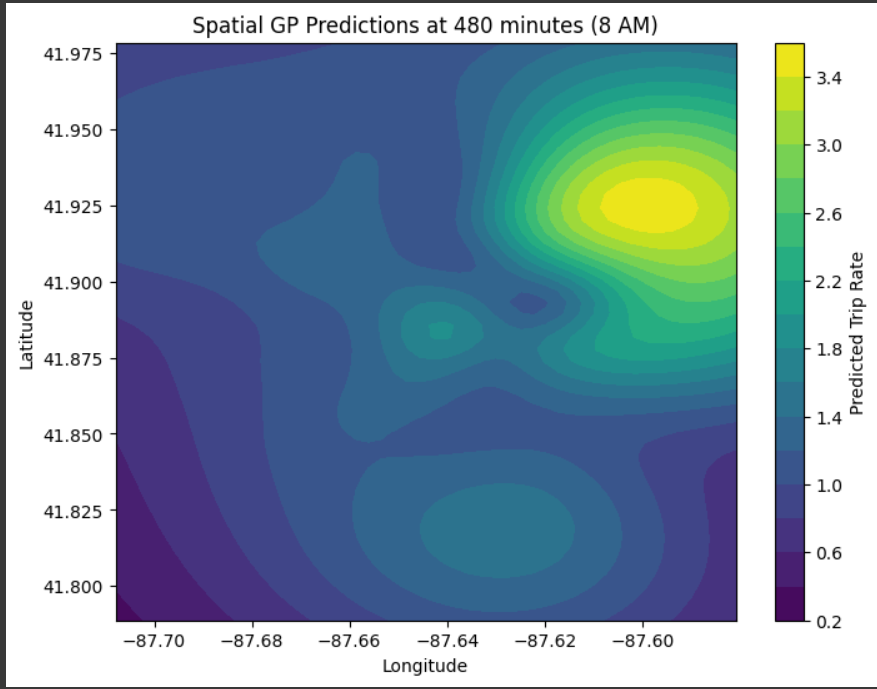

Post Pickle

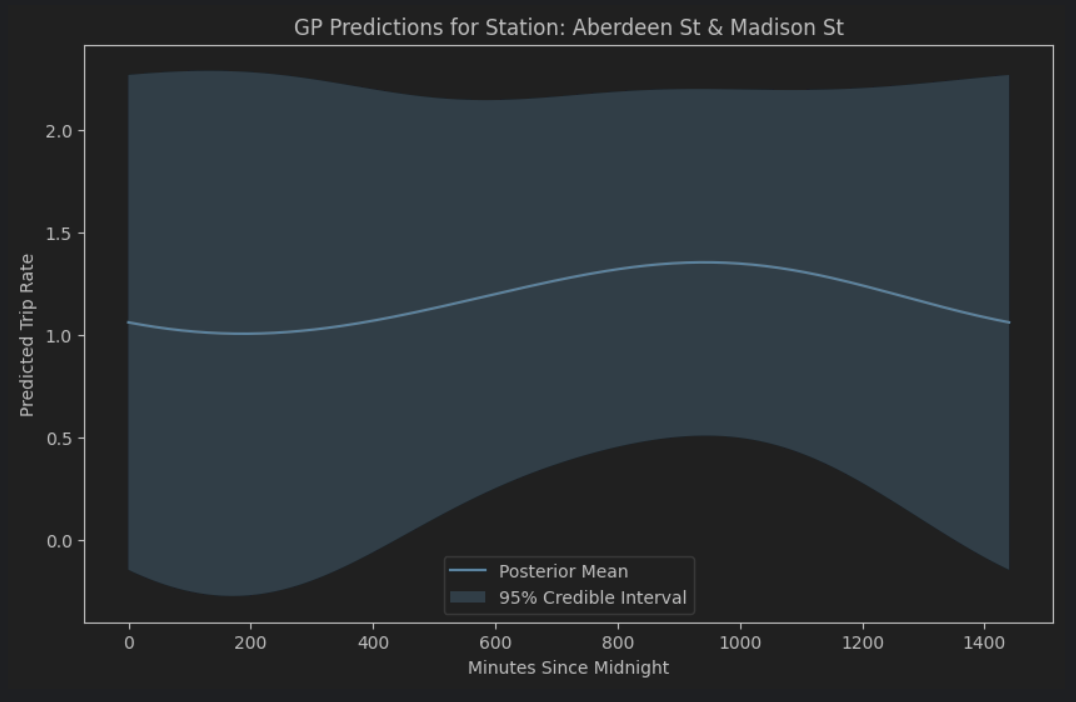

It turns out the problem was mostly in how i tried to reimplement the pickled model, i can still mostly work with the model i built, I just need to only use the pickled trace and redefine the model from now.

In [180]:
with open('gp_model.pkl', 'rb') as buff:
    data1 = pickle.load(buff)
trace = data1['trace']


In [181]:
m = 100
X_u = X[np.random.choice(X.shape[0], size=m, replace=False)]

with pm.Model() as gp_model:
    ls_time = pm.Gamma("ls_time", alpha=2, beta=1)
    period = 1440
    cov_time = pm.gp.cov.Periodic(3, ls=ls_time, period=period, active_dims=[0])

    ls_space = pm.Gamma("ls_space", alpha=2, beta=1)
    cov_space = pm.gp.cov.Matern52(3, ls=ls_space, active_dims=[1, 2])

    cov = cov_time * cov_space
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")

    sigma = pm.HalfCauchy("sigma", beta=5)
    y_obs = gp.marginal_likelihood("y_obs", X=X, y=y, noise=sigma, Xu=X_u)



/usr/local/lib/python3.11/dist-packages/pymc/gp/gp.py:933: FutureWarning: gp.MarginalSparse has been renamed to gp.MarginalApprox.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pymc/gp/gp.py:55: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


Visualization Time!

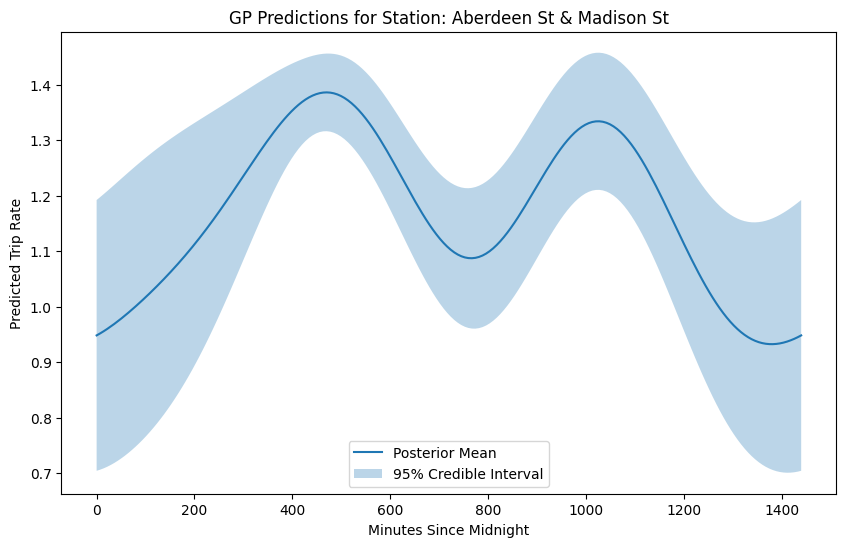

In [182]:
import numpy as np
import matplotlib.pyplot as plt

# Station to analyze
station = "Aberdeen St & Madison St"
station_lat, station_lon = station_coords[station]

# Create a grid of times (in minutes since midnight)
time_grid = np.linspace(0, 1440, 200)  # 200 points across the day

# Build new input array for predictions: each row is [time, latitude, longitude]
new_X_time = np.column_stack([
    time_grid,
    np.full_like(time_grid, station_lat),
    np.full_like(time_grid, station_lon)
])

# Predict using GP
with gp_model:
    point = {
        "ls_time": trace.posterior["ls_time"].mean().item(),
        "ls_space": trace.posterior["ls_space"].mean().item(),
        "sigma": trace.posterior["sigma"].mean().item()
    }
    pred_mean, pred_var = gp.predict(new_X_time, point=point, diag=True)

pred_std = np.sqrt(pred_var)

# Plot the GP predictions with uncertainty bands
plt.figure(figsize=(10, 6))
plt.plot(time_grid, pred_mean, label="Posterior Mean")
plt.fill_between(time_grid, pred_mean - 2*pred_std, pred_mean + 2*pred_std, alpha=0.3, label="95% Credible Interval")
plt.xlabel("Minutes Since Midnight")
plt.ylabel("Predicted Trip Rate")
plt.title(f"GP Predictions for Station: {station}")
plt.legend()
plt.show()

Cool, this clearly captures a morning and afternoon rush. Let's try the most popular station, and this time overlay the data

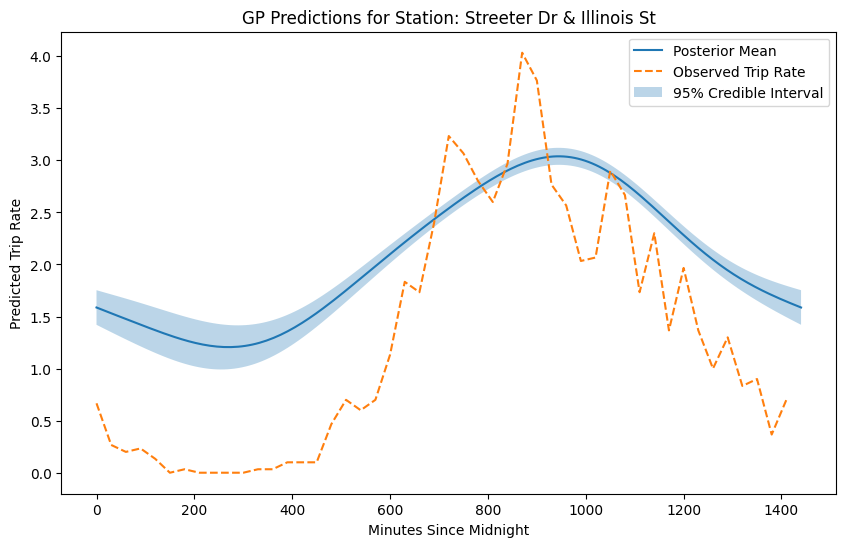

In [183]:
import numpy as np
import matplotlib.pyplot as plt

station = "Streeter Dr & Illinois St"
station_lat, station_lon = station_coords[station]

time_grid = np.linspace(0, 1440, 200)

new_X_time = np.column_stack([
    time_grid,
    np.full_like(time_grid, station_lat),
    np.full_like(time_grid, station_lon)
])

with gp_model:
    point = {
        "ls_time": trace.posterior["ls_time"].mean().item(),
        "ls_space": trace.posterior["ls_space"].mean().item(),
        "sigma": trace.posterior["sigma"].mean().item()
    }
    pred_mean, pred_var = gp.predict(new_X_time, point=point, diag=True)

pred_std = np.sqrt(pred_var)

station_data = grouped[grouped['from_station_name'] == station]
observed_trips = station_data.groupby('time_bin')['trips'].sum()

# Reindex observed_trips to match the length of time_grid
observed_trips = observed_trips.reindex(np.arange(0, 1440, 30), fill_value=0)

observed_trip_rate = observed_trips / 30  # Calculate trip rate

plt.figure(figsize=(10, 6))
plt.plot(time_grid, pred_mean, label="Posterior Mean")

plt.plot(observed_trip_rate.index, observed_trip_rate.values, label="Observed Trip Rate", linestyle='dashed')

plt.fill_between(time_grid, pred_mean - 2*pred_std, pred_mean + 2*pred_std, alpha=0.3, label="95% Credible Interval")
plt.xlabel("Minutes Since Midnight")
plt.ylabel("Predicted Trip Rate")
plt.title(f"GP Predictions for Station: {station}")
plt.legend()
plt.show()

The model definitely smooths things out a bit too much, and is very very confident about it. It underestimates the highs and overestimates the lows. This probably in part because of the influence that the other nearby positions have on the output here. The model sees two nearby positions as almost the same thing. It see's the entire map as having an output and it's arbitrary whether we pick from one place or the place right next to it. The function is continuous, so they should have almost the same output. In reality, however, those are completely distinct stations. People can't just rent a bike wherever, so this model was never going to perfectly predict the actual rented bike numbers. It does, however, provide a really interesting view into the popularity or vibrancy of regions at given points in time.

HEATMAP, here are a bunch of different times and their associated heatmap

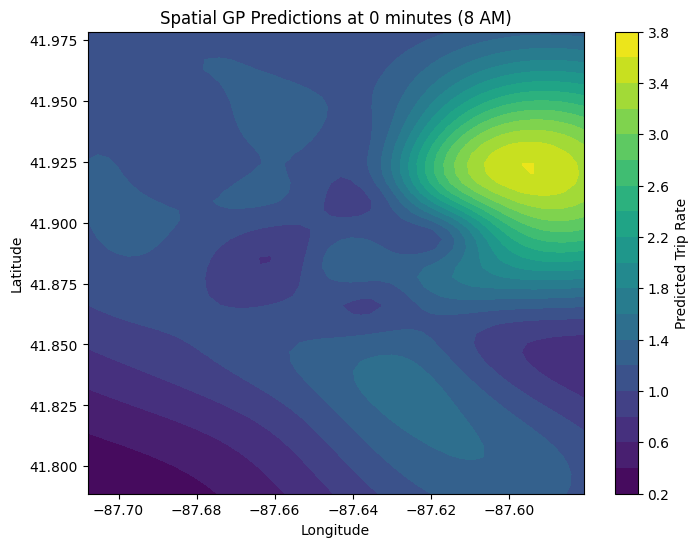

In [184]:
import matplotlib.pyplot as plt

fixed_time = 0

# Define the spatial grid bounds
lat_min, lat_max = grouped["latitude"].min(), grouped["latitude"].max()
lon_min, lon_max = grouped["longitude"].min(), grouped["longitude"].max()

# Create grid points
grid_size = 50
lat_grid = np.linspace(lat_min, lat_max, grid_size)
lon_grid = np.linspace(lon_min, lon_max, grid_size)
lat_mesh, lon_mesh = np.meshgrid(lat_grid, lon_grid)

# Flatten the grid to create input for GP predictions
# Each input is [fixed_time, latitude, longitude]
new_X_space = np.column_stack([
    np.full(lat_mesh.flatten().shape, fixed_time),
    lat_mesh.flatten(),
    lon_mesh.flatten()
])

with gp_model:
    # Create a dictionary with the mean values of the parameters
    point = {
        "ls_time": trace.posterior["ls_time"].mean().item(),
        "ls_space": trace.posterior["ls_space"].mean().item(),
        "sigma": trace.posterior["sigma"].mean().item()
    }
    spatial_pred_mean, spatial_pred_var = gp.predict(new_X_space, point=point, diag=True)

spatial_pred_mean = spatial_pred_mean.reshape(lat_mesh.shape)


# Plot heatmap
plt.figure(figsize=(8, 6))
contour = plt.contourf(lon_mesh, lat_mesh, spatial_pred_mean, cmap='viridis', levels=20)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Spatial GP Predictions at {fixed_time} minutes (8 AM)")
plt.colorbar(contour, label="Predicted Trip Rate")
plt.show()

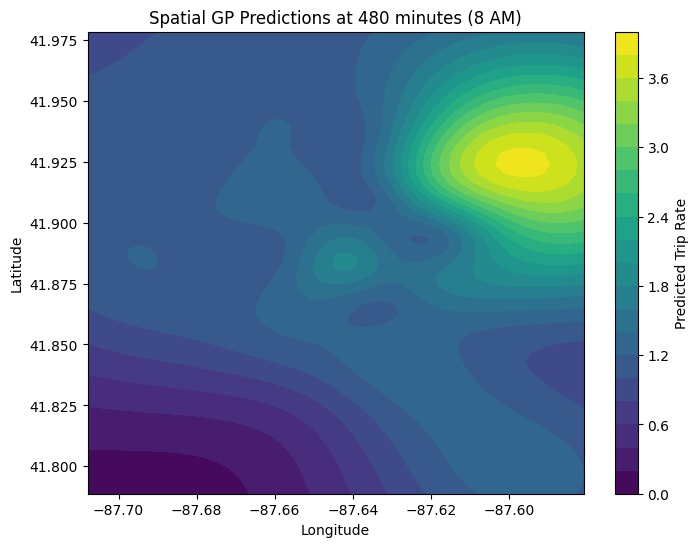

In [189]:
import matplotlib.pyplot as plt

fixed_time = 480

# Define the spatial grid bounds
lat_min, lat_max = grouped["latitude"].min(), grouped["latitude"].max()
lon_min, lon_max = grouped["longitude"].min(), grouped["longitude"].max()

# Create grid points
grid_size = 50
lat_grid = np.linspace(lat_min, lat_max, grid_size)
lon_grid = np.linspace(lon_min, lon_max, grid_size)
lat_mesh, lon_mesh = np.meshgrid(lat_grid, lon_grid)

# Flatten the grid to create input for GP predictions
# Each input is [fixed_time, latitude, longitude]
new_X_space = np.column_stack([
    np.full(lat_mesh.flatten().shape, fixed_time),
    lat_mesh.flatten(),
    lon_mesh.flatten()
])

with gp_model:
    # Create a dictionary with the mean values of the parameters
    point = {
        "ls_time": trace.posterior["ls_time"].mean().item(),
        "ls_space": trace.posterior["ls_space"].mean().item(),
        "sigma": trace.posterior["sigma"].mean().item()
    }
    spatial_pred_mean, spatial_pred_var = gp.predict(new_X_space, point=point, diag=True)

spatial_pred_mean = spatial_pred_mean.reshape(lat_mesh.shape)


# Plot heatmap
plt.figure(figsize=(8, 6))
contour = plt.contourf(lon_mesh, lat_mesh, spatial_pred_mean, cmap='viridis', levels=20)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Spatial GP Predictions at {fixed_time} minutes (8 AM)")
plt.colorbar(contour, label="Predicted Trip Rate")
plt.show()

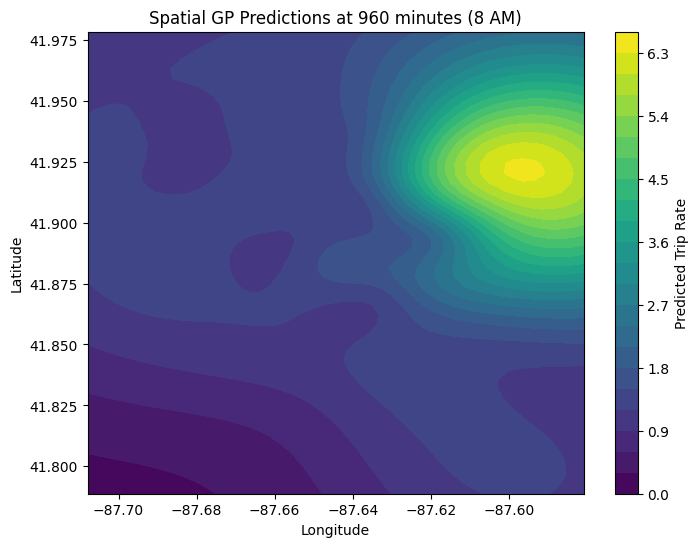

In [190]:
import matplotlib.pyplot as plt

fixed_time = 960

# Define the spatial grid bounds
lat_min, lat_max = grouped["latitude"].min(), grouped["latitude"].max()
lon_min, lon_max = grouped["longitude"].min(), grouped["longitude"].max()

# Create grid points
grid_size = 50
lat_grid = np.linspace(lat_min, lat_max, grid_size)
lon_grid = np.linspace(lon_min, lon_max, grid_size)
lat_mesh, lon_mesh = np.meshgrid(lat_grid, lon_grid)

# Flatten the grid to create input for GP predictions
# Each input is [fixed_time, latitude, longitude]
new_X_space = np.column_stack([
    np.full(lat_mesh.flatten().shape, fixed_time),
    lat_mesh.flatten(),
    lon_mesh.flatten()
])

with gp_model:
    # Create a dictionary with the mean values of the parameters
    point = {
        "ls_time": trace.posterior["ls_time"].mean().item(),
        "ls_space": trace.posterior["ls_space"].mean().item(),
        "sigma": trace.posterior["sigma"].mean().item()
    }
    spatial_pred_mean, spatial_pred_var = gp.predict(new_X_space, point=point, diag=True)

spatial_pred_mean = spatial_pred_mean.reshape(lat_mesh.shape)


# Plot heatmap
plt.figure(figsize=(8, 6))
contour = plt.contourf(lon_mesh, lat_mesh, spatial_pred_mean, cmap='viridis', levels=20)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Spatial GP Predictions at {fixed_time} minutes (8 AM)")
plt.colorbar(contour, label="Predicted Trip Rate")
plt.show()

Here's that same thing but there's a slider to adjust what time you're looking at

In [187]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display

def update_heatmap(fixed_time):
    with gp_model:
        point = {
            "ls_time": trace.posterior["ls_time"].mean().item(),
            "ls_space": trace.posterior["ls_space"].mean().item(),
            "sigma": trace.posterior["sigma"].mean().item()
        }
        # Update the inputs with the current fixed time
        new_X_space = np.column_stack([
            np.full(lat_mesh.flatten().shape, fixed_time),
            lat_mesh.flatten(),
            lon_mesh.flatten()
        ])
        spatial_pred_mean, _ = gp.predict(new_X_space, point=point, diag=True)
    spatial_pred_mean = spatial_pred_mean.reshape(lat_mesh.shape)

    plt.figure(figsize=(8, 6))
    contour = plt.contourf(lon_mesh, lat_mesh, spatial_pred_mean, cmap='viridis', levels=20)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Spatial GP Predictions at {fixed_time} minutes")
    plt.colorbar(contour, label="Predicted Trip Rate")
    plt.show()

# Create a slider for time (from 0 to 1440 minutes)
time_slider = widgets.IntSlider(min=0, max=1440, step=10, value=480, description="Time (min)")
widgets.interact(update_heatmap, fixed_time=time_slider)


interactive(children=(IntSlider(value=480, description='Time (min)', max=1440, step=10), Output()), _dom_class…

<function __main__.update_heatmap(fixed_time)>

And heres a gif version

Global min: 0.08314969622379675 Global max: 6.414595964366923


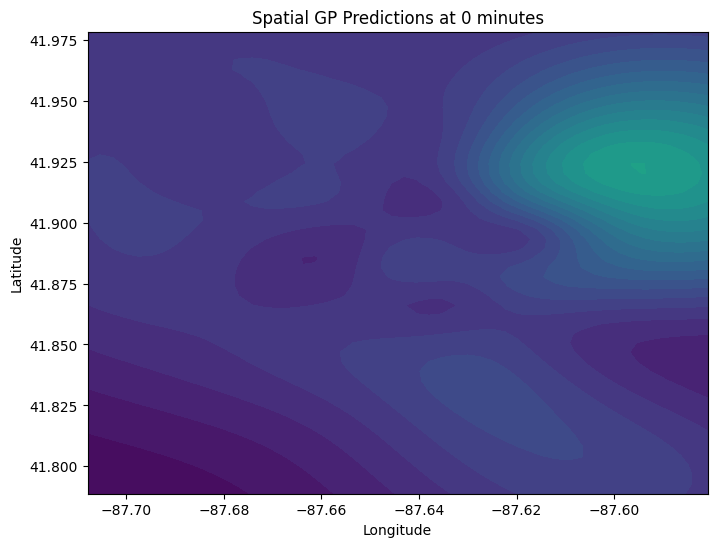

In [188]:

import matplotlib.animation as animation
from IPython.display import HTML

lat_flat = lat_mesh.flatten()
lon_flat = lon_mesh.flatten()

with gp_model:
    point = {
        "ls_time": trace.posterior["ls_time"].mean().item(),
        "ls_space": trace.posterior["ls_space"].mean().item(),
        "sigma": trace.posterior["sigma"].mean().item()
    }

def predict_at_time(t):
    new_X = np.column_stack([np.full(lat_flat.shape, t), lat_flat, lon_flat])
    with gp_model:
        pred_mean, _ = gp.predict(new_X, point=point, diag=True)
    return pred_mean.reshape(lat_mesh.shape)

# Make Predictions and record global max and min so the color scale is consistent
sample_times = np.arange(0, 1440, 60)
predictions = [predict_at_time(t) for t in sample_times]
global_min = min(pred.min() for pred in predictions)
global_max = max(pred.max() for pred in predictions)
print("Global min:", global_min, "Global max:", global_max)


fig, ax = plt.subplots(figsize=(8, 6))

def animate(t):
    ax.clear()
    spatial_pred_mean = predict_at_time(t)
    contour = ax.contourf(lon_mesh, lat_mesh, spatial_pred_mean, cmap='viridis',
                           levels=20, vmin=global_min, vmax=global_max)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"Spatial GP Predictions at {t} minutes")
    return contour.collections if hasattr(contour, "collections") else []

anim = animation.FuncAnimation(fig, animate, frames=sample_times.tolist(), interval=500, blit=False)
HTML(anim.to_jshtml())


This project was very very cool, but I spent a lot of time trying to make a running model at all, and I didn't get to think very hard about the specific choices I was making and how that affects my predictions. My prior was probably way too strong, and I likely did a whole host of careless other things that prevented my model from working perfectly. To be honest, for actually predicting things, picking a model that takes 12 hours to run is not the best. There was no shopping for the best predictions, I just had to take what I could get. Nonetheless, I made some very pretty pictures, so that's cool.